In [1]:
#imports
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
import HSS
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 
font = {#'family' : 'Helvetica',
        'size'   : 16}

In [2]:
path_plot = '/users/caganze/research/stellarstreams/figures/streamssims/'
path_data = '/users/caganze/research/stellarstreams/data/'

In [3]:
#use NFW POTENTIAL BECAUSE THE HALO? 
import astropy.coordinates as coord
_ = coord.galactocentric_frame_defaults.set('v4.0')

#chat
#pot = gp.NFWPotential.from_circular_velocity(v_c=220*u.km/u.s, r_s=15*u.kpc, units=galactic)
pot=gp.MilkyWayPotential()#
#CONSTRUCT A HAMILTONIAN
H = gp.Hamiltonian(pot)

In [4]:
def generate_stream(mass, prog_w0,   dt=-1.*u.Myr, tmin=0*u.Gyr, tmax=-0.1*u.Gyr):
    df = ms.FardalStreamDF()
    prog_mass = mass * u.Msun
    gen = ms.MockStreamGenerator(df, H)
    stream, prog = gen.run(prog_w0, prog_mass ,dt=dt, t1=tmin, t2=tmax,   progress=True)
    return stream, prog

In [5]:
def generate_stream_and_perturber(mass, prog_w0,  nbody=None, output_every=None,\
                                  dt=-1.*u.Myr, tmin=0*u.Gyr, output_filename=None, tmax=-0.1*u.Gyr):
    df = ms.FardalStreamDF()
    prog_mass = mass * u.Msun
    gen = ms.MockStreamGenerator(df, H)

    return gen.run(prog_w0, prog_mass, nbody=nbody, release_every=1, \
        n_particles=1, output_every=output_every, output_filename= output_filename, \
                    check_filesize=True, overwrite=True, progress=True,\
                   dt=dt,t1=tmin, t2=tmax)


In [6]:
def ptmass_acceleration(xyz, M):
    """
    This function computes the 3D acceleration vector at a
    position or an array of positions "xyz" from a point mass
    with mass "M" at the origin.

    Parameters
    ----------
    xyz : quantity-like
        This should have shape (3, ...)
    M : quantity-like
        The total mass of the point mass.

    """
    r3 = np.sum(xyz ** 2, axis=0) ** (3 / 2)
    dPhi_dx = G * M * xyz / r3
    return -dPhi_dx

def ptmass_potential(xyz, M):
    """
    Compute the potential energy from a point mass at the given
    position(s) ``xyz``.

    Parameters
    ----------
    xyz : quantity-like
    M : quantity-like
    """
    r = np.sqrt(np.sum(xyz ** 2, axis=0))
    return -G * M / r

In [7]:
def run_stream_and_subhalo(halo_mass, stream_mass, halo_r, halo_pos, stream_pos,
                           filename='mockstream',  dt=1.*u.Myr, \
                                      tmin=-0.5*u.Gyr, tmax=0.5*u.Gyr, \
                                    output_every=20, potential_type='plummer'):
    """
    runs a subhalo and a stream 
    
    returns the progenitor position and the final stream
    """
    
    #create a plummer sphere 
    point_potential=gp.PlummerPotential(halo_mass*u.Msun,  halo_r, units=galactic)
    
    #if potential_type
    if  potential_type.lower()=='hernquist':
        point_potential=gp.HernquistPotential(halo_mass*u.Msun,  halo_r, units=galactic)
        
    #create an Nbody potential object
    Massive_body=gd.DirectNBody(halo_pos, [point_potential], external_potential=pot)
    
    return  generate_stream_and_perturber(stream_mass,  stream_pos,  \
                                      nbody=Massive_body, dt=dt, \
                                      tmin= tmin, tmax=tmax, \
                                    output_every=output_every, \
                                    output_filename=path_data+'/'+filename)
    
    
def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    return body, stream_cont

In [8]:
def trace_orbits(stream_cont, body):
    body_pos=body['pos']
   

    print (np)
    fig, (ax, ax1)=plt.subplots(figsize=(12, 4), ncols=2)

    ax.plot(body_pos[0], body_pos[1],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    
    ax1.scatter(stream_pos[0][idx], stream_pos[-1][idx],  s=1, alpha=0.5, c='k', label='Stream')
    ax1.scatter(body_pos[0][idx], body_pos[-1][idx],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    

In [10]:
def plot_stream_and_body(idx, stream_cont, body, time_dict, \
                        xlim=[-5, 5], ylim=[-5, 5], zlim=[-5, 5]):
    
    body_pos=body['pos']
    stream_pos=stream_cont['pos']
    
    t= time_dict['tmin']+20*idx*time_dict['dt']
    t=t.to(u.Myr)
    
    fig, (ax, ax1, ax2)=plt.subplots(figsize=(12, 4), ncols=3)
    
    fig.suptitle('T = {}  Timesetep = {}'.format(t,idx ), fontsize=16)

    
    ax.scatter(stream_pos[0][idx], stream_pos[1][idx],  s=1, alpha=0.5, c='k', label='Stream')
    ax.scatter(body_pos[0][idx], body_pos[1][idx],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    
    
    ax1.scatter(stream_pos[0][idx], stream_pos[-1][idx],  s=1, alpha=0.5, c='k', label='Stream')
    ax1.scatter(body_pos[0][idx], body_pos[-1][idx],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    
    ax2.scatter((stream_pos[0][idx]**2+stream_pos[1][idx]**2)**0.5, \
                stream_pos[-1][idx],  s=1, alpha=0.5, c='k', label='Stream')
    ax2.scatter((body_pos[0][idx]**2+body_pos[1][idx]**2)**0.5, \
                body_pos[-1][idx],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    
    

    ax.minorticks_on()
    ax1.minorticks_on()

    ax1.legend(fontsize=14)
    ax.set(xlabel='x (pc)', ylabel='y (pc)')
    ax1.set(xlabel='x (pc)', ylabel='z (pc)')
    ax2.set(xlabel=r'$(x^2+z^2)^{0.5}$ (pc)', ylabel='z (pc)')
    
    ax.set(xlim=xlim, ylim=ylim)
    ax1.set(xlim=xlim, ylim=zlim)
    ax2.set(xlim=xlim, ylim=zlim)
    
    plt.tight_layout()
    
    
    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    


    return image

In [11]:
st_pos=gd.PhaseSpacePosition(pos=  [ 9.05141523, -8.46952618, -0.3829373 ]* u.kpc,
                                 vel=[  2.02138101, -91.931178  ,  25.61559275]  * u.km/u.s)
halo_pos=gd.PhaseSpacePosition(pos= [11.20662338,  1.12066234,  4.25588309]  * u.kpc,
                                 vel=[  87.38721999,    8.738722  , -123.90393607]* u.km/u.s)


In [12]:
mstream=5e5
mhalo=1e10
halo_r=20*u.pc
tmax=1.*u.Gyr
dt=1.*u.Myr
filename='herquinst_halomass{:.1e}_streammass{:.1e}_halorad{}_tmax{}_dt{}'.format(mhalo, \
                                                                                  mstream, halo_r, tmax, dt)
time_dict={'tmin': -500*u.Myr, 'tmax': tmax,  'dt': dt}

In [13]:
out = run_stream_and_subhalo(mhalo, mstream, halo_r,st_pos,  halo_pos,
                           filename=filename, tmin=time_dict['tmin'],\
                           tmax=time_dict['tmax'], dt=time_dict['dt'], potential_type='hernquist')

Integrating orbits:  100%

In [14]:
stream_p, nbody_p= out 

In [20]:
bd, st=read_stream_file(filename)

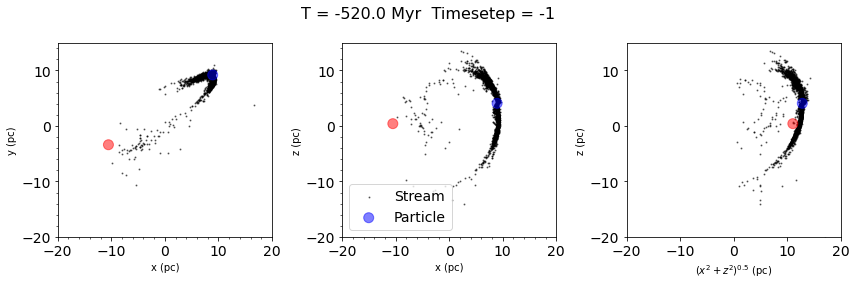

In [34]:
_= plot_stream_and_body(-1, st, bd, time_dict,  xlim=[-20, 20], ylim=[-20, 15], zlim=[-20, 15])

<ipython-input-10-a12c4b369d1c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax, ax1, ax2)=plt.subplots(figsize=(12, 4), ncols=3)



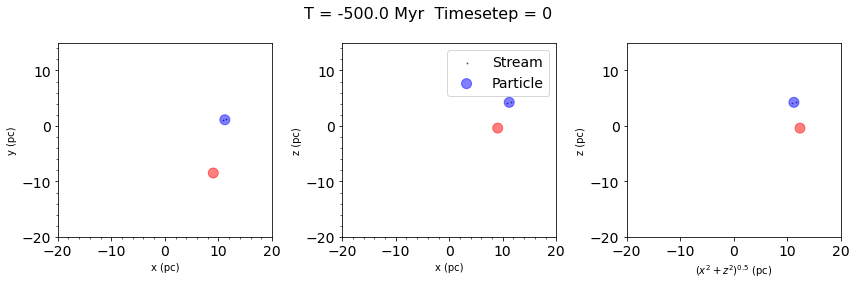

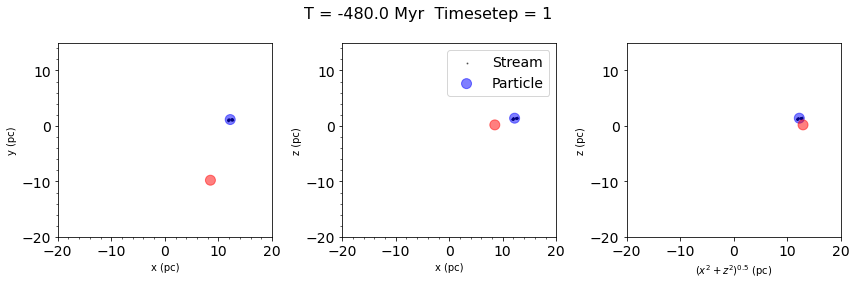

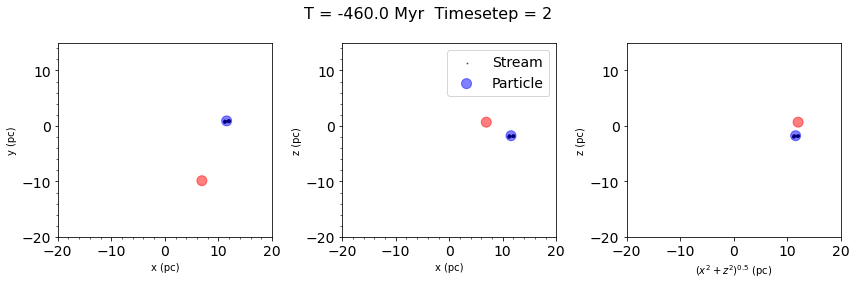

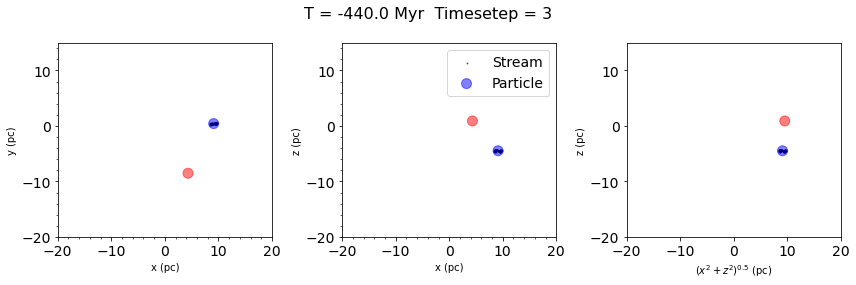

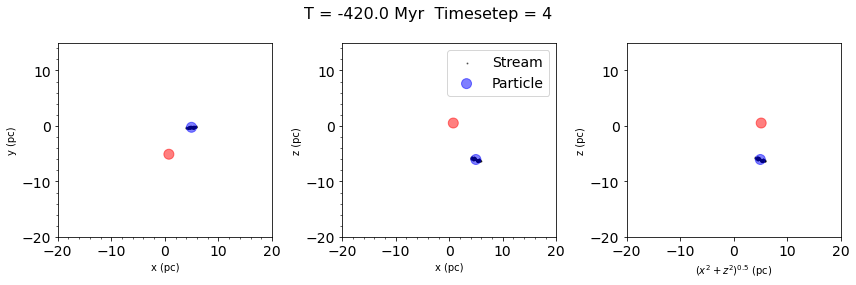

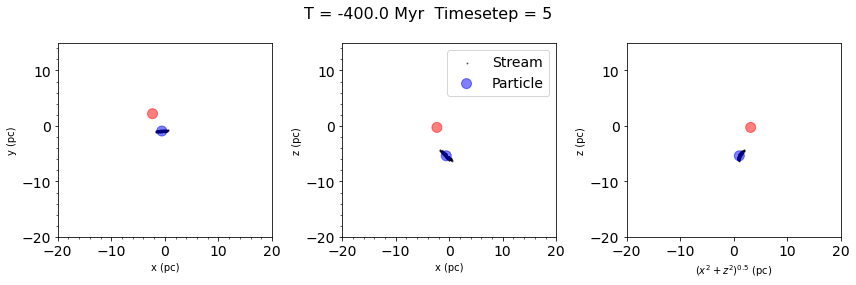

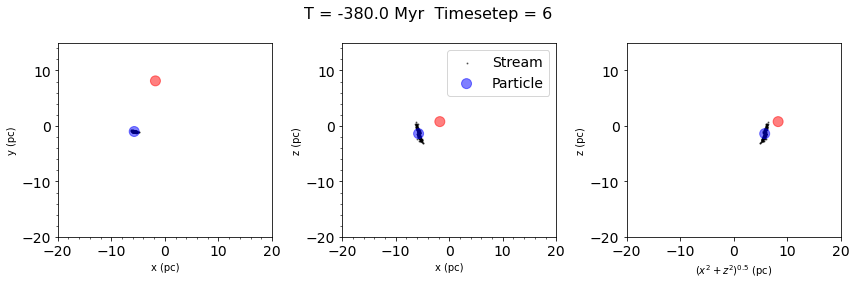

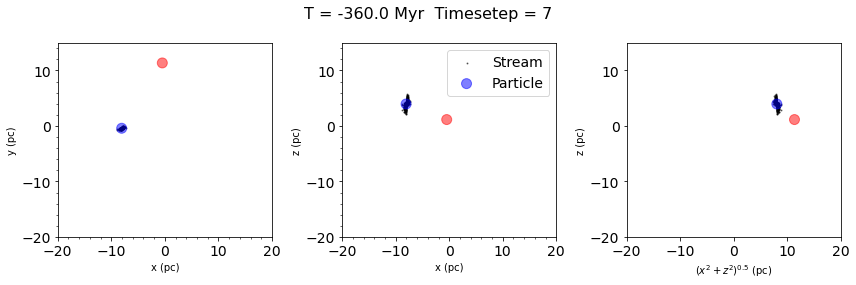

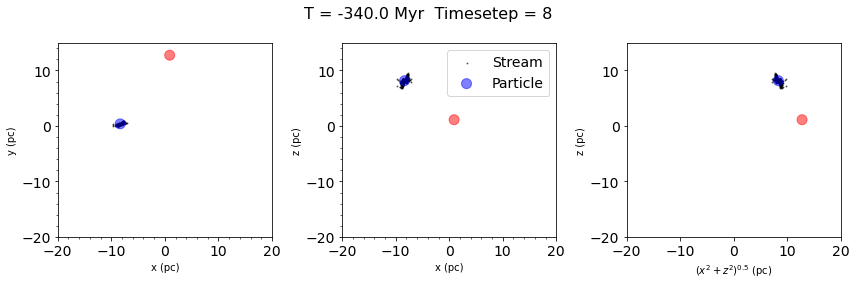

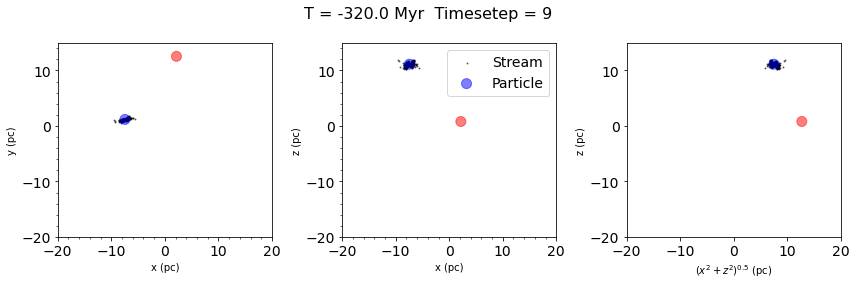

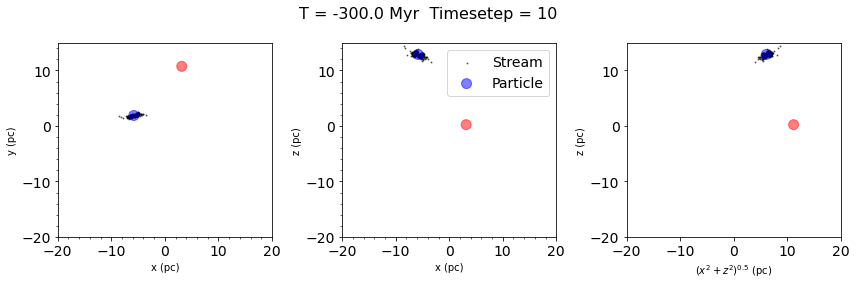

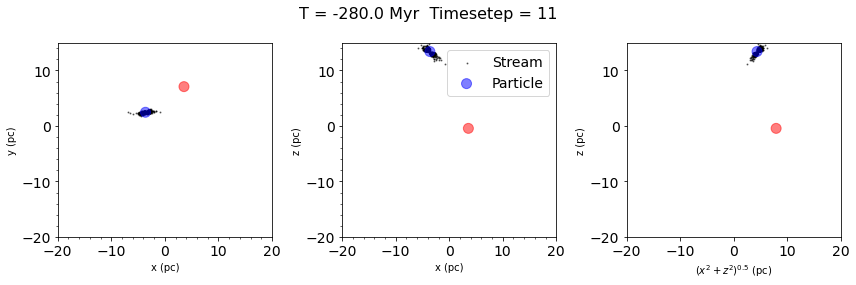

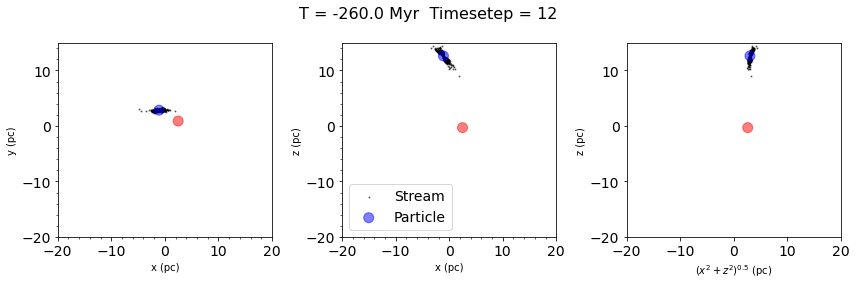

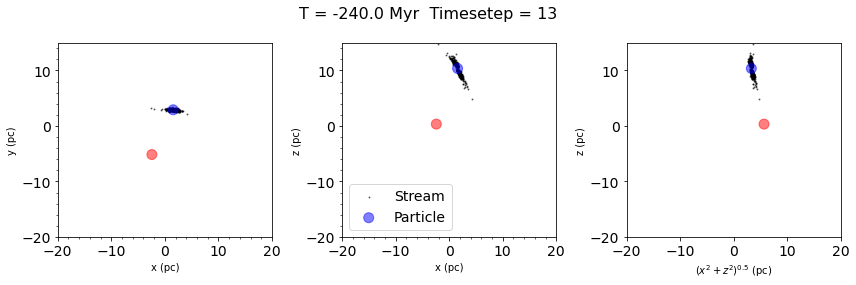

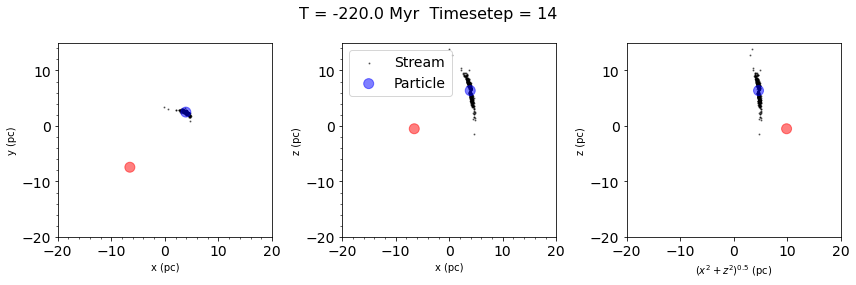

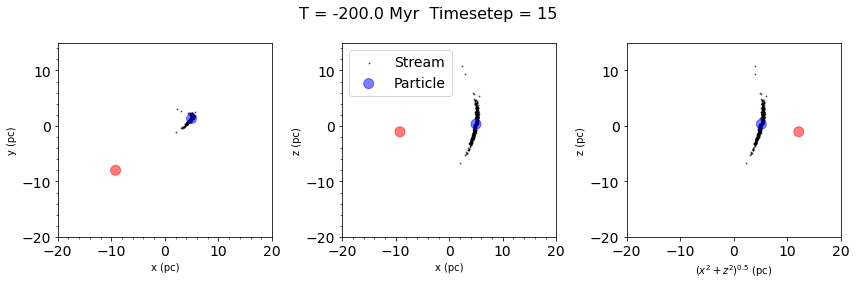

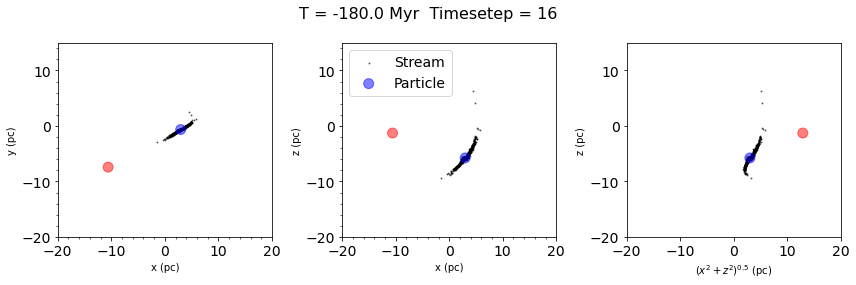

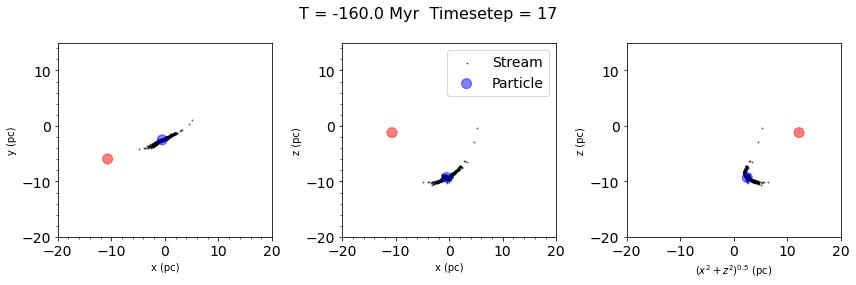

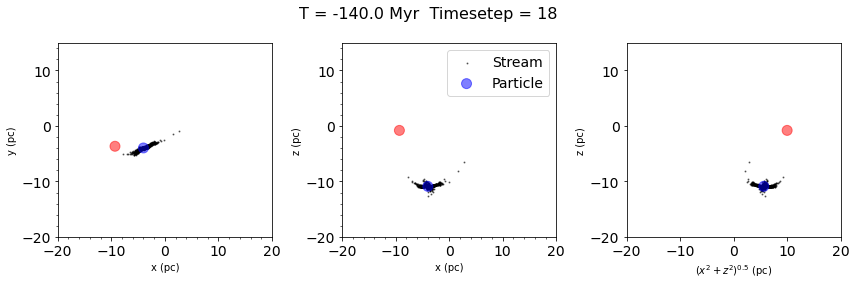

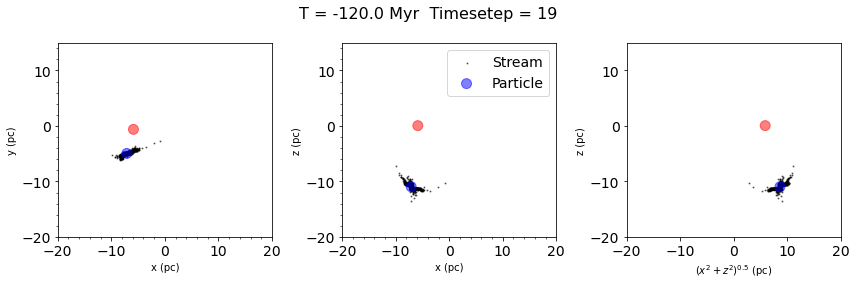

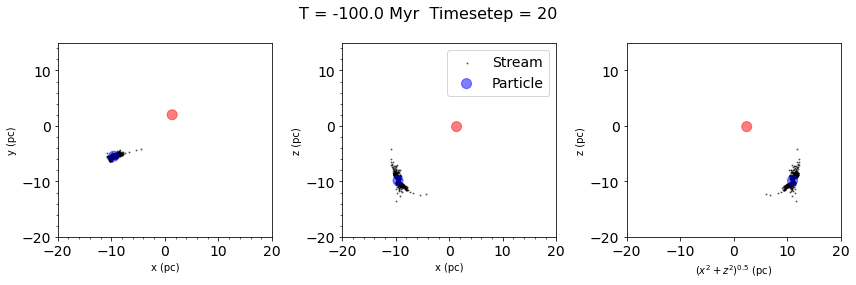

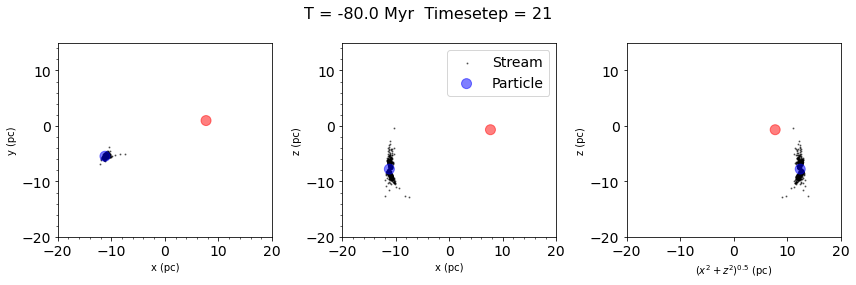

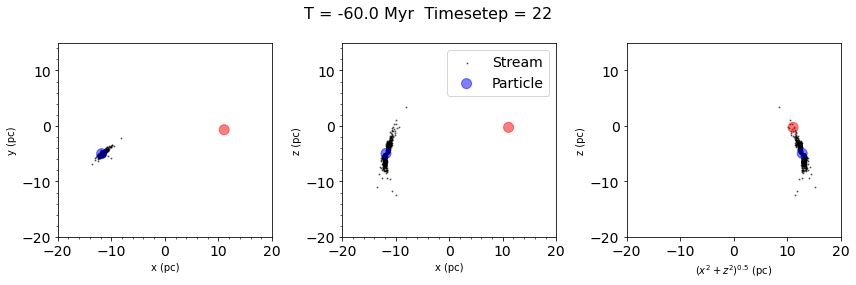

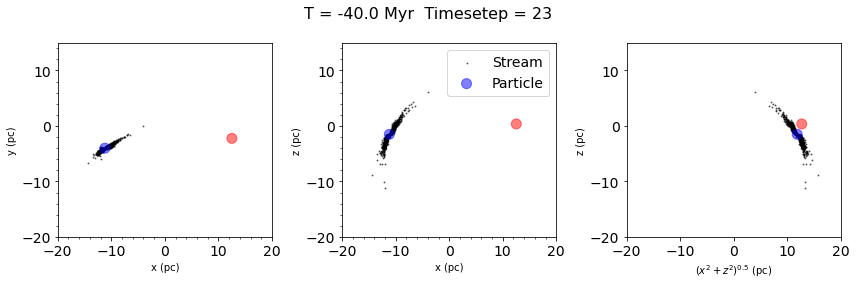

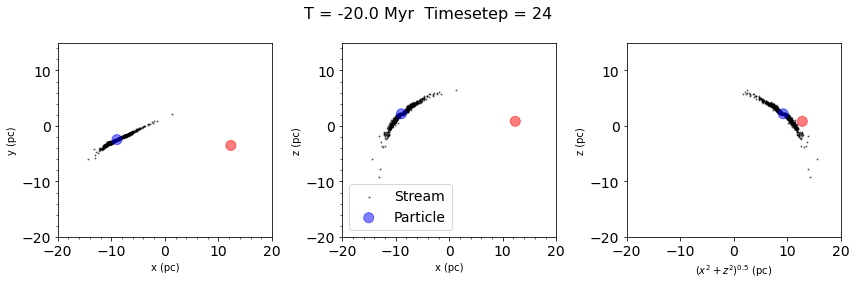

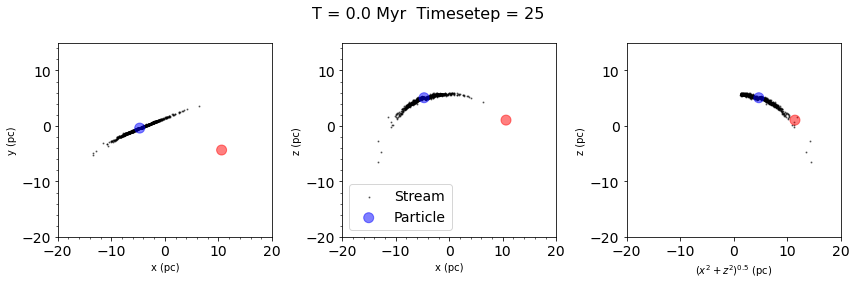

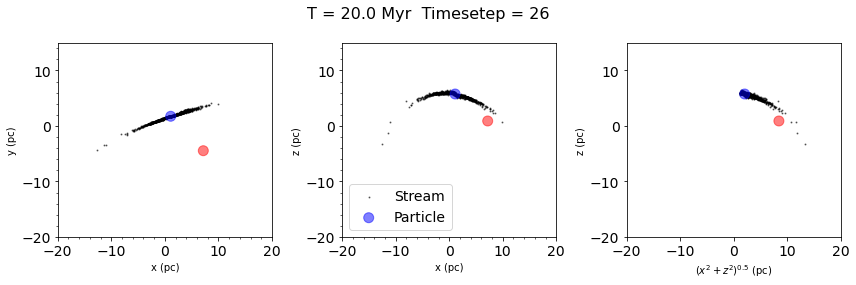

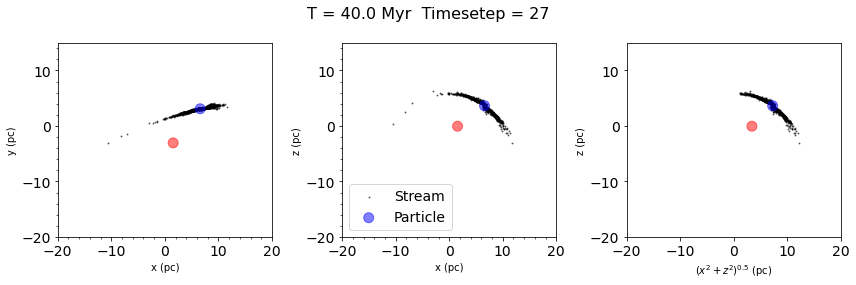

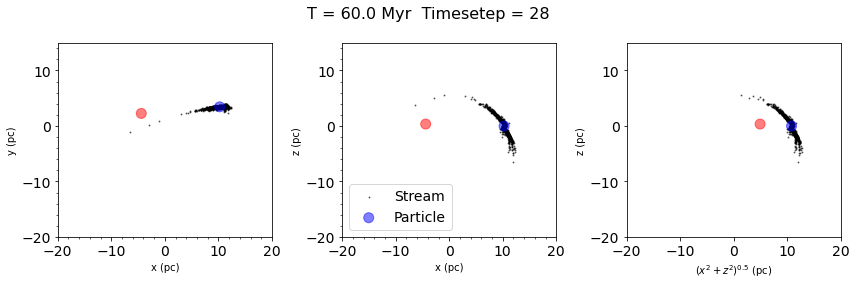

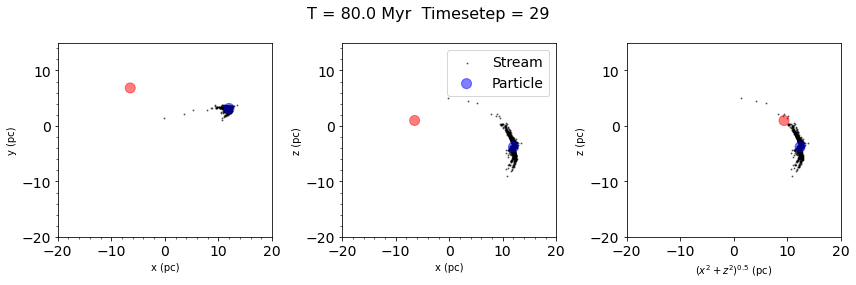

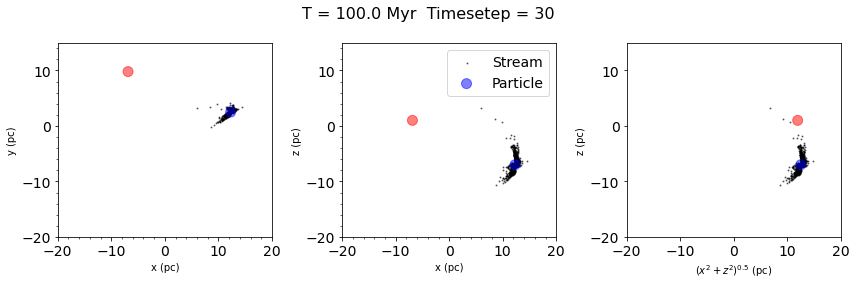

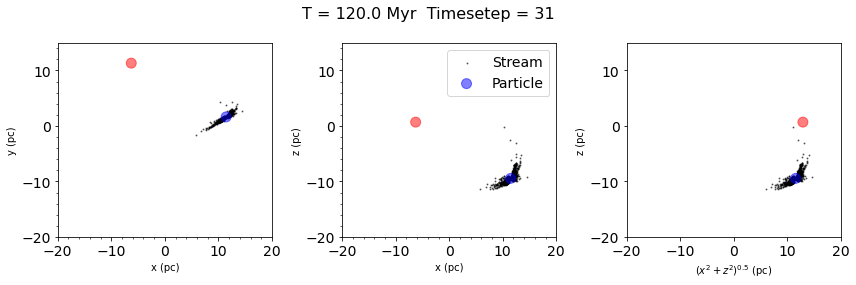

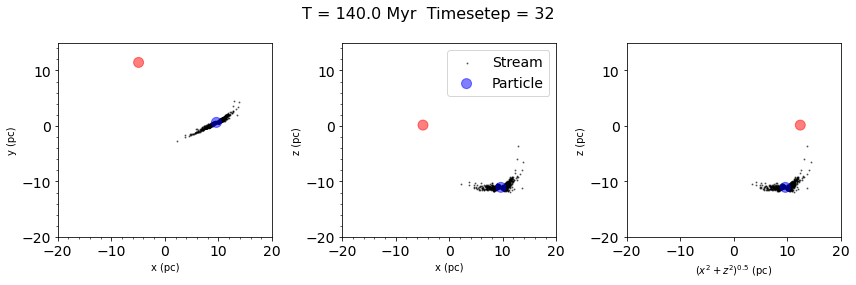

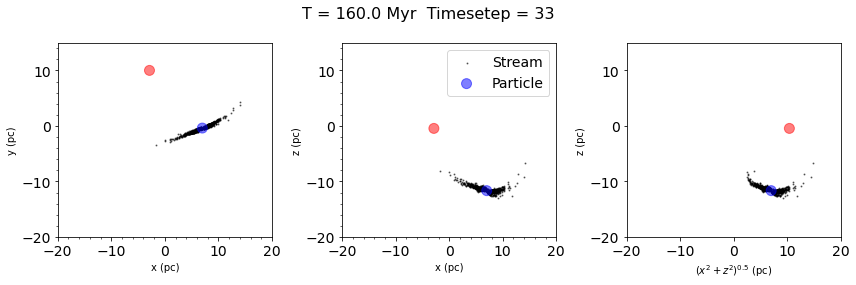

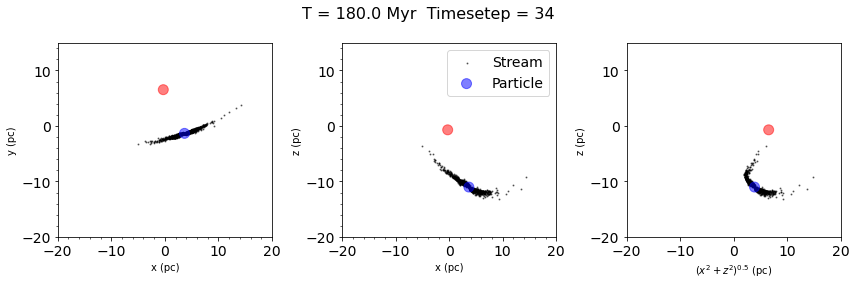

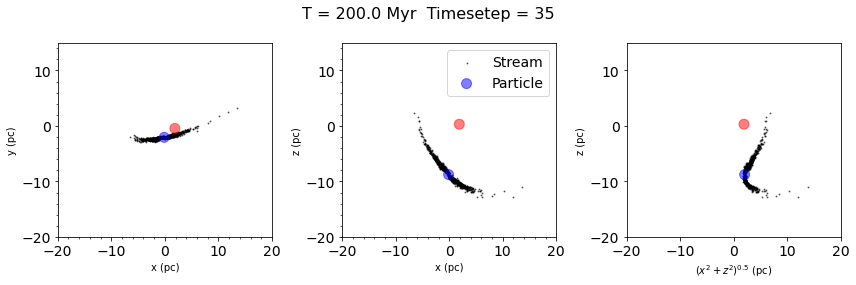

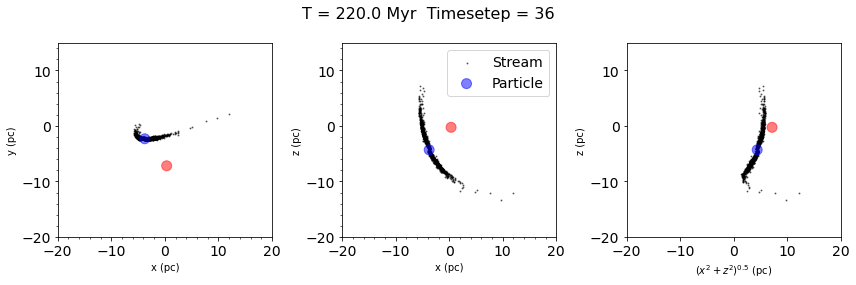

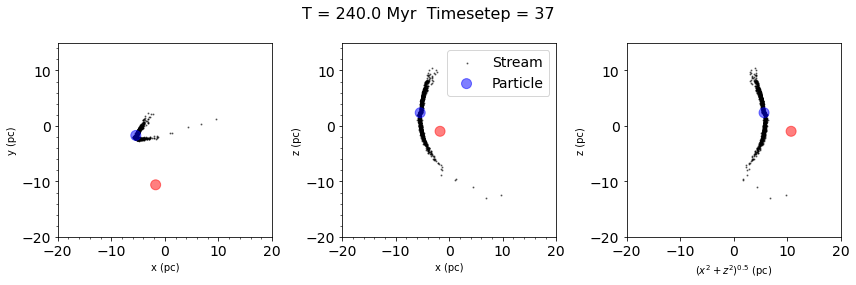

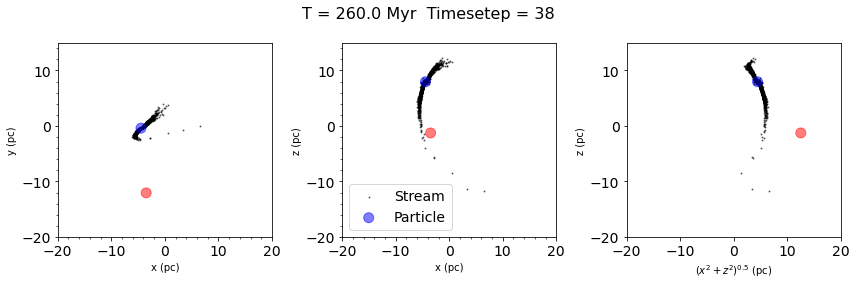

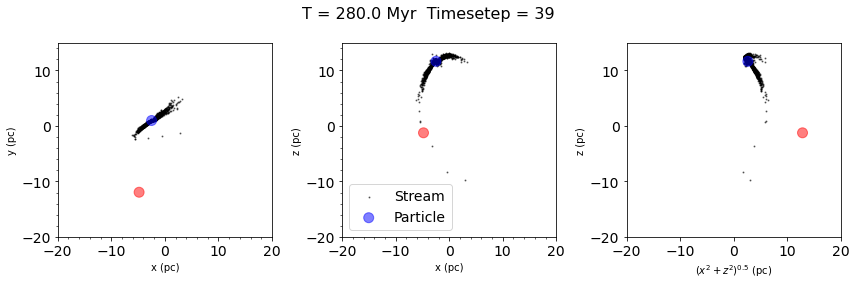

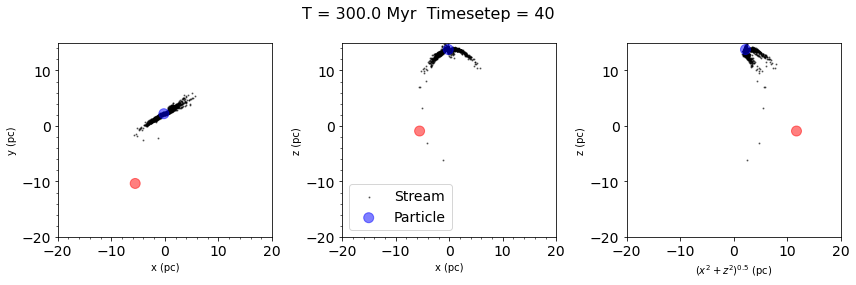

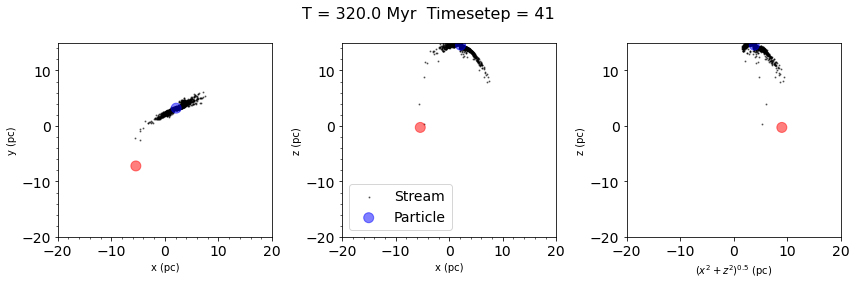

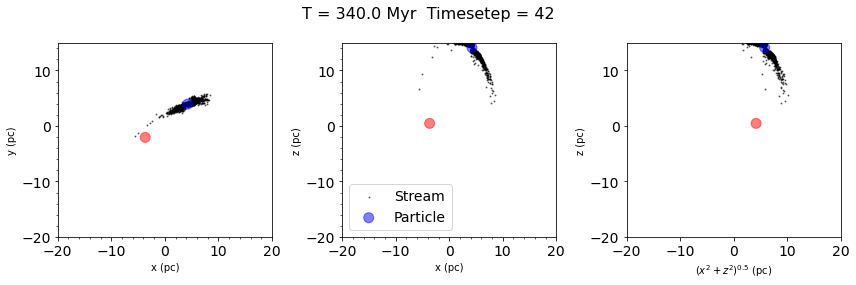

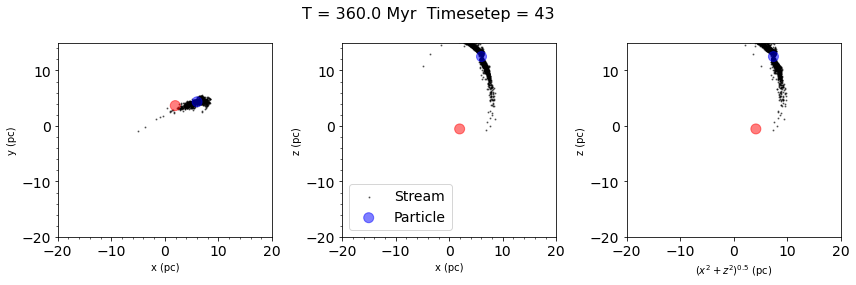

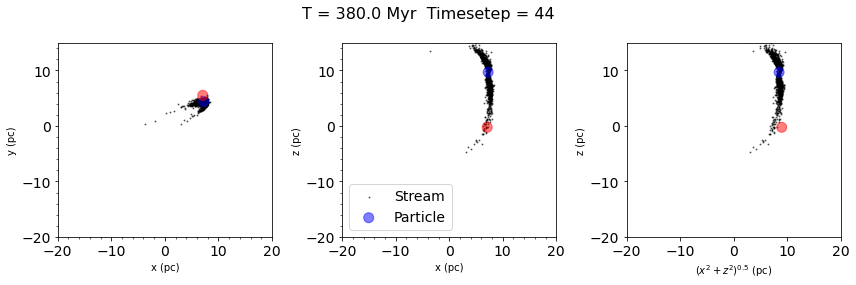

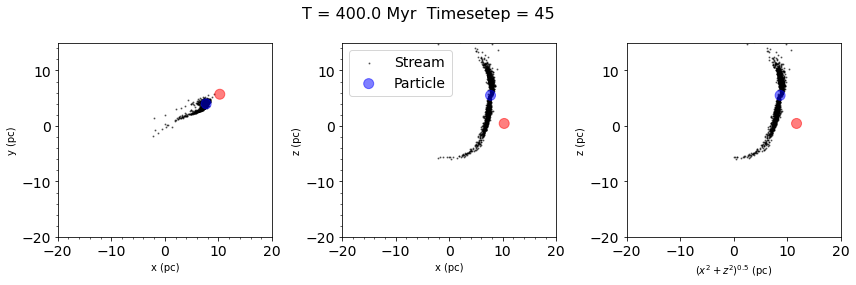

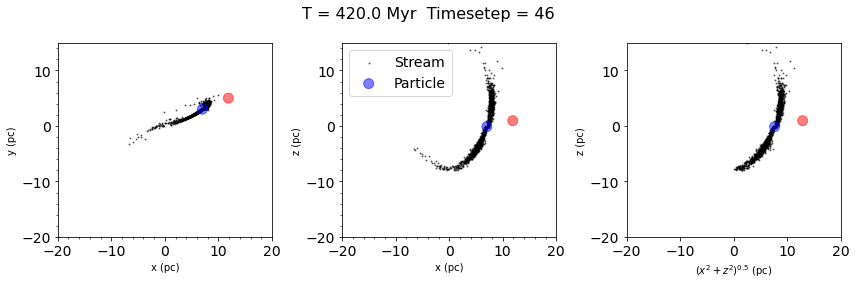

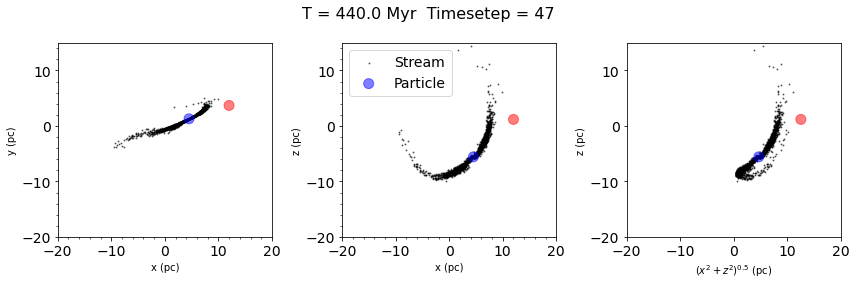

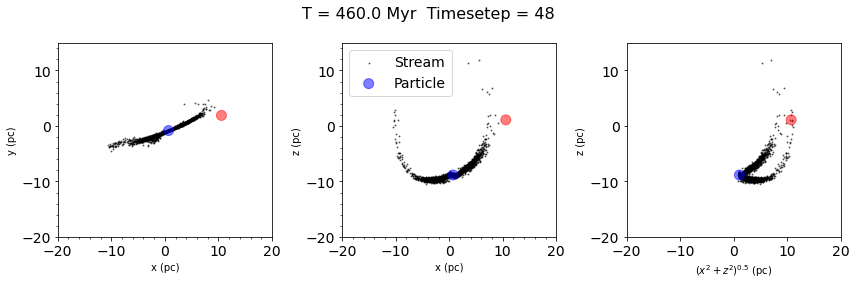

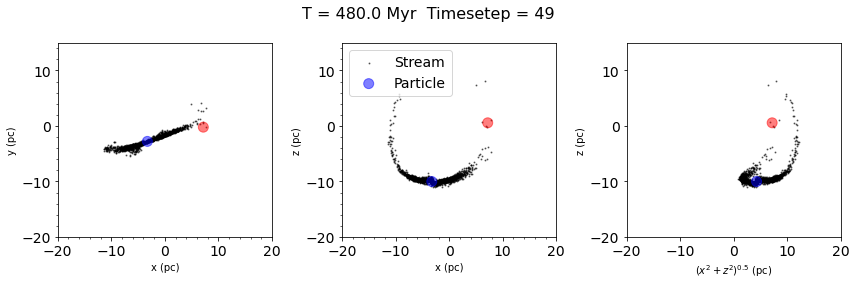

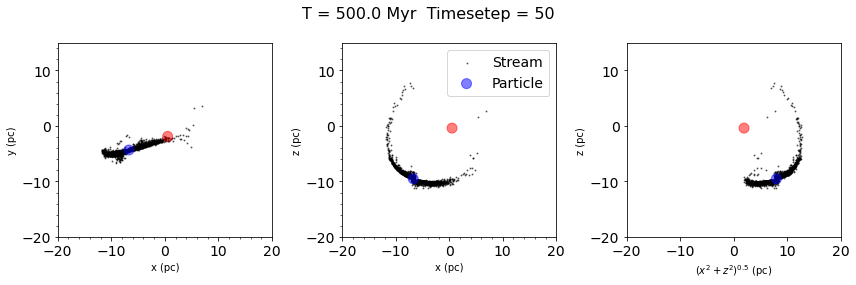

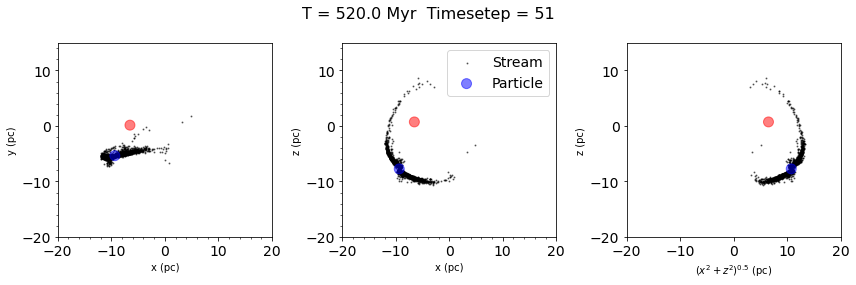

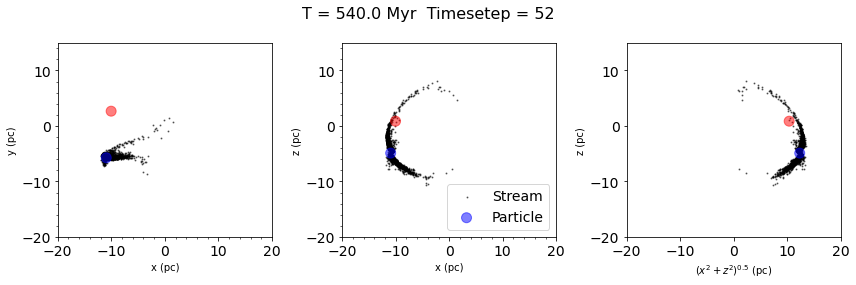

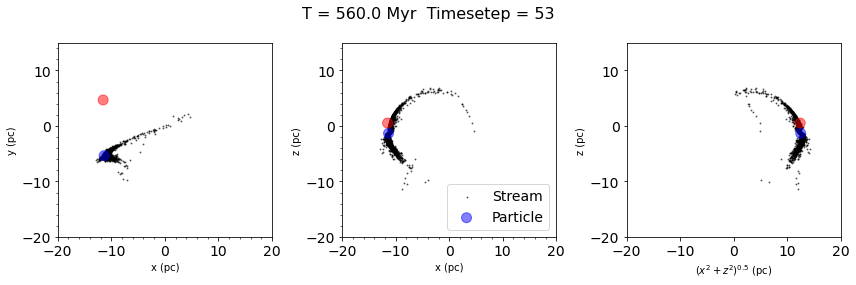

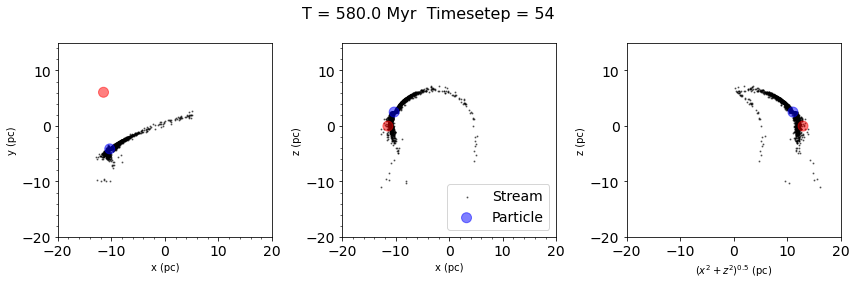

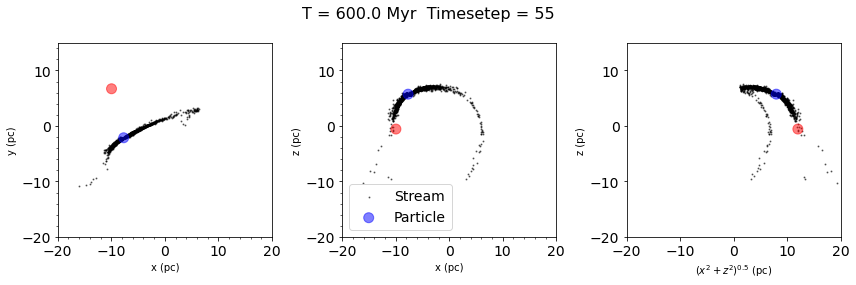

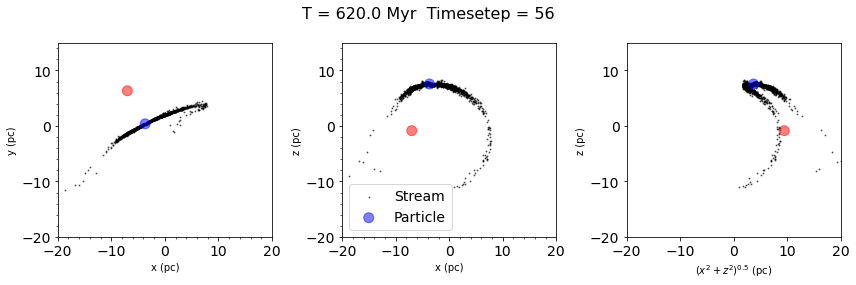

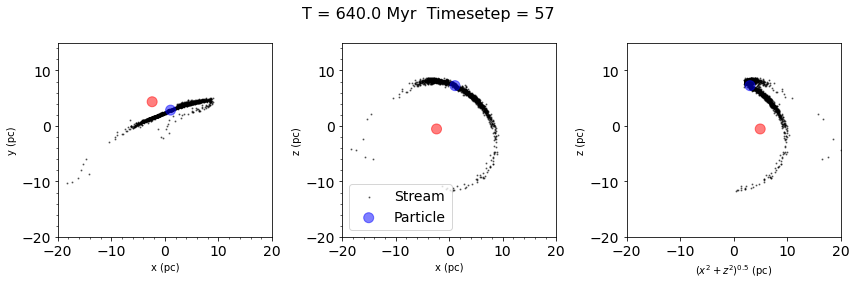

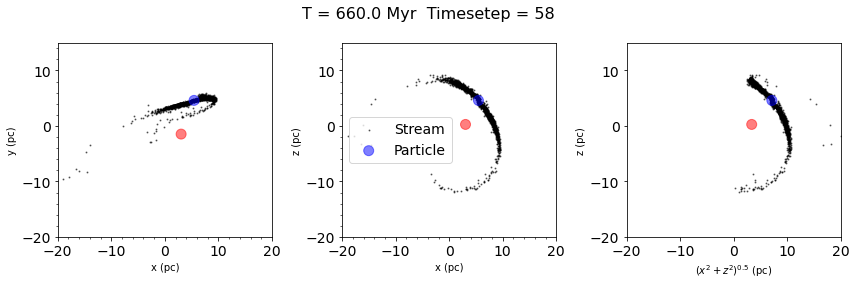

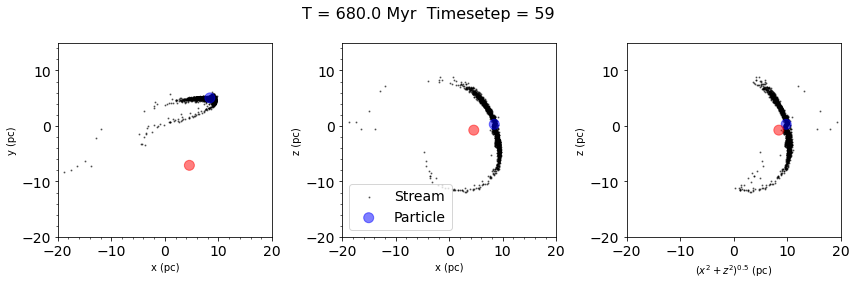

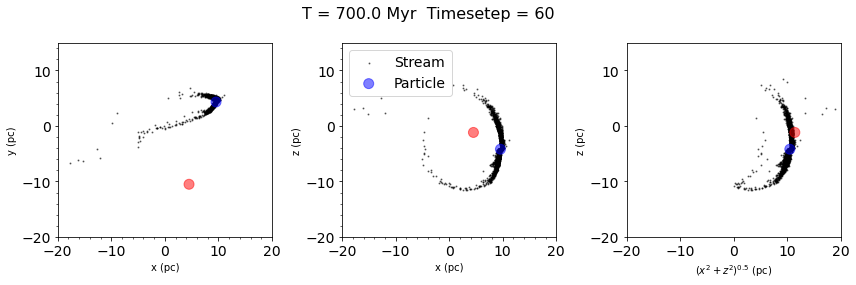

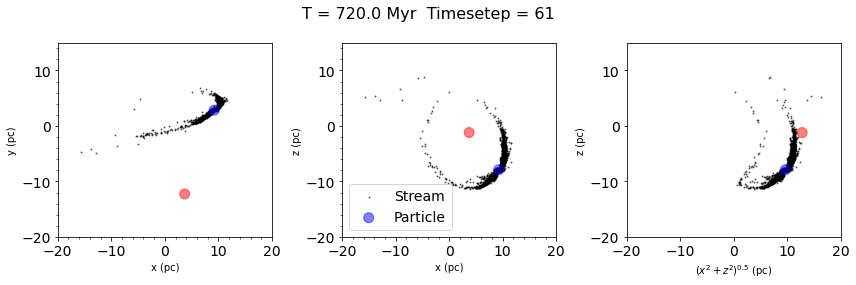

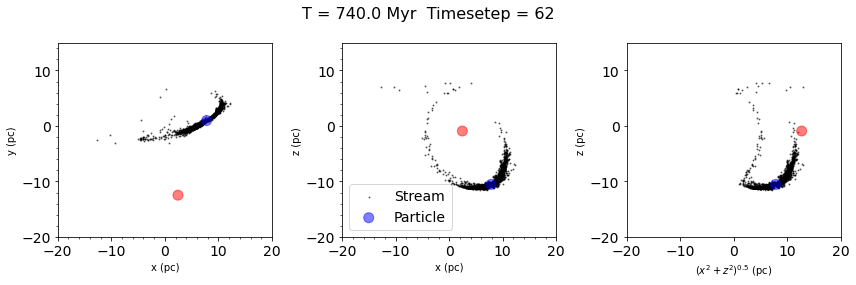

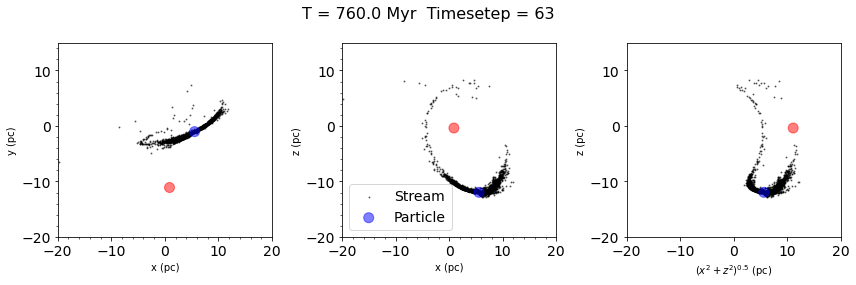

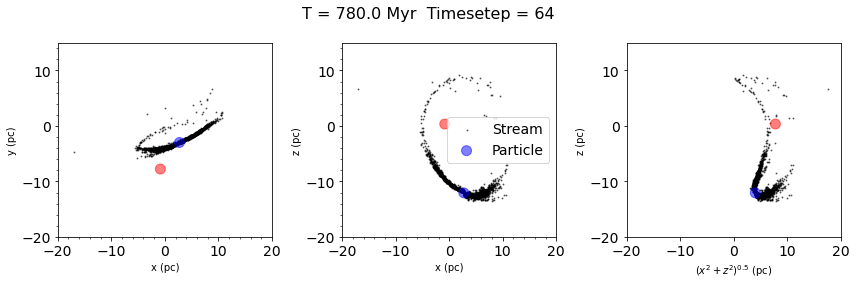

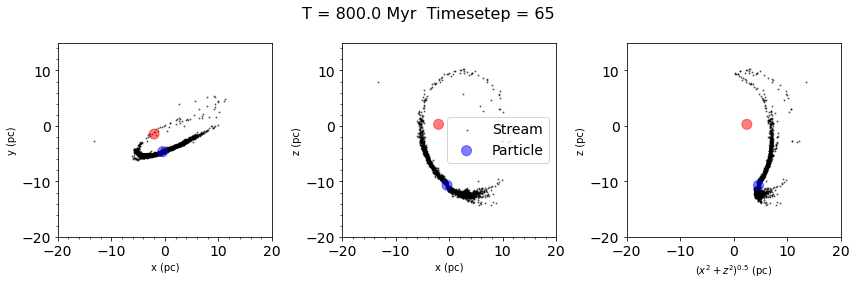

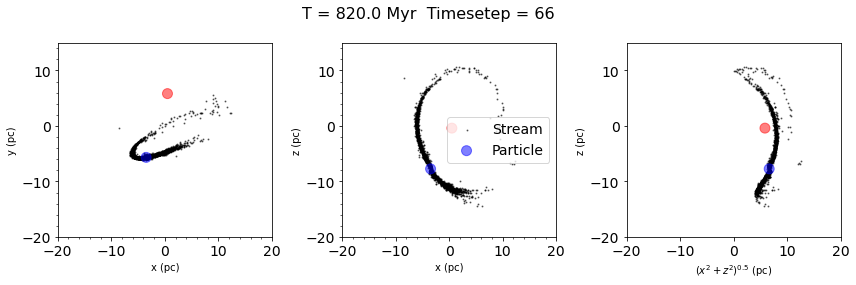

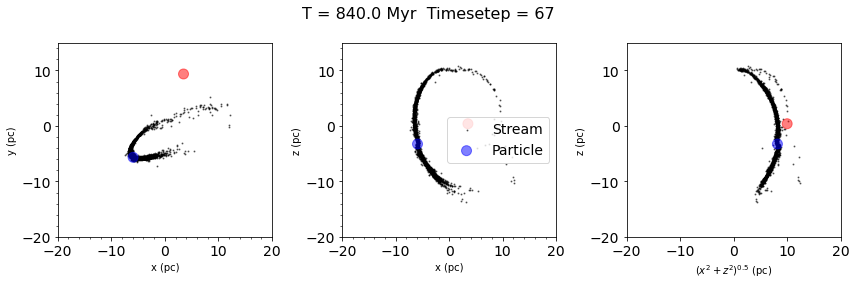

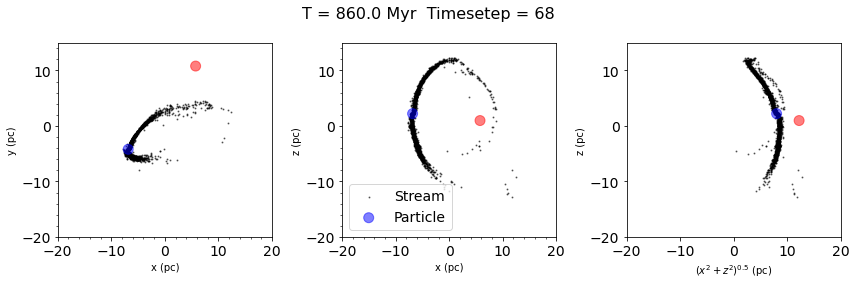

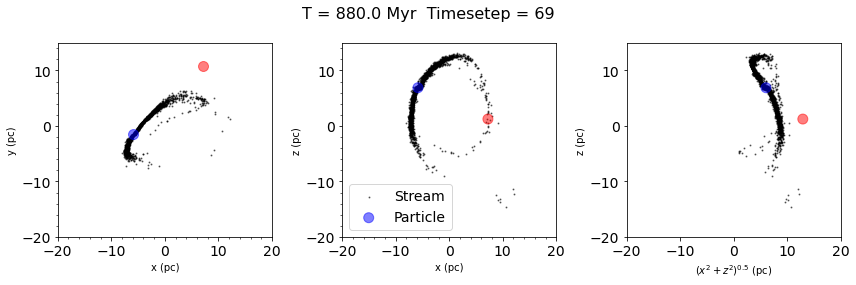

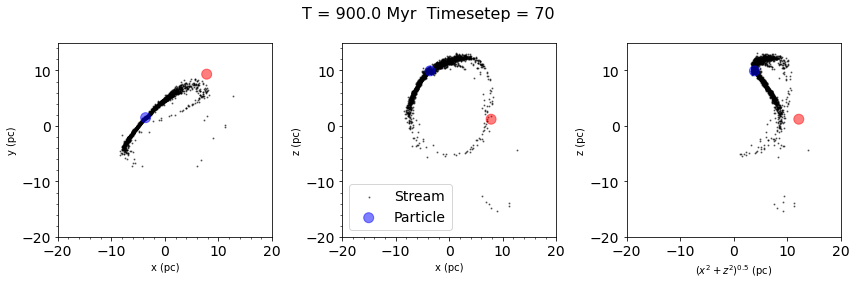

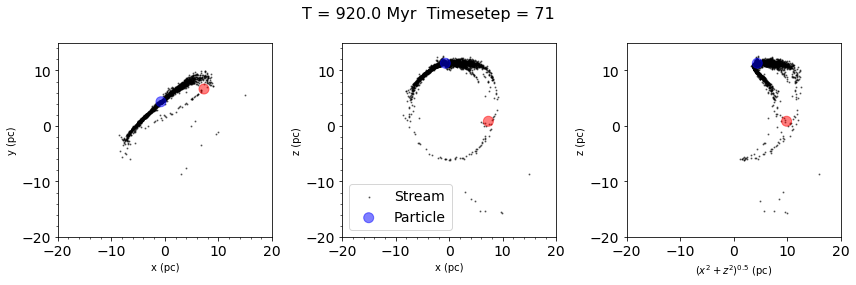

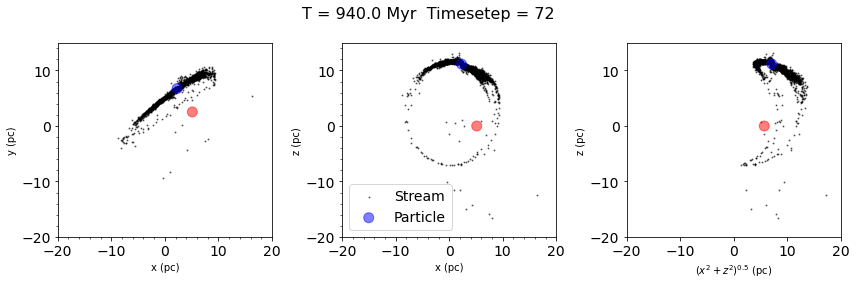

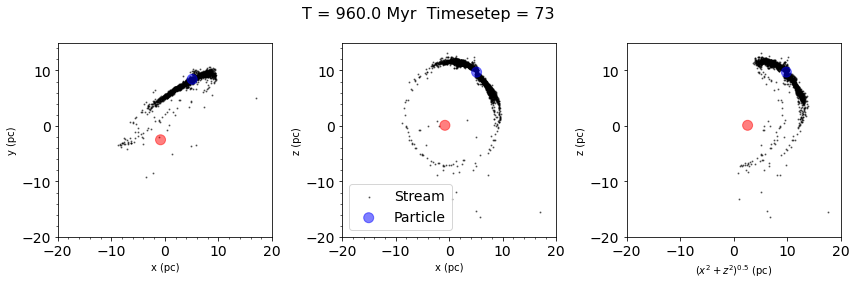

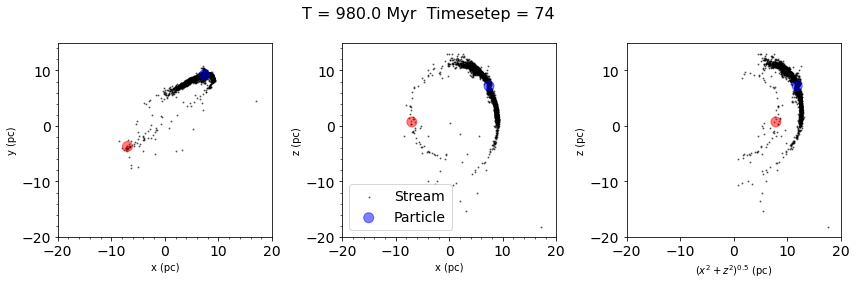

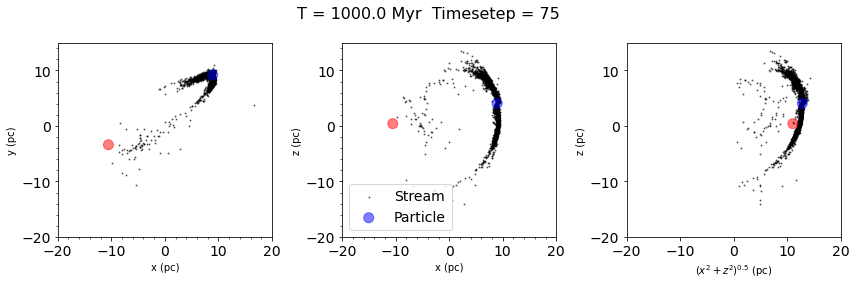

In [33]:
kwargs_write = {'fps':10.0, 'quantizer':'nq'}
_= imageio.mimsave(path_plot+'/'+ filename+'.gif',\
                   [ plot_stream_and_body(i, st, bd, time_dict,\
                    xlim=[-20, 20], ylim=[-20, 15], zlim=[-20, 15]) for i in \
                                     np.arange(bd['pos'].shape[1])], \
                   fps=1)

In [23]:
stream_c = stream_p.to_coord_frame(coord.ICRS)

/opt/anaconda3/lib/python3.8/site-packages/astropy/coordinates/baseframe.py:1207: AstropyDeprecationWarning: Transforming a frame instance to a frame class (as opposed to another frame instance) will not be supported in the future.  Either explicitly instantiate the target frame, or first convert the source frame instance to a `astropy.coordinates.SkyCoord` and use its `transform_to()` method.
  warnings.warn("Transforming a frame instance to a frame class (as opposed to another "



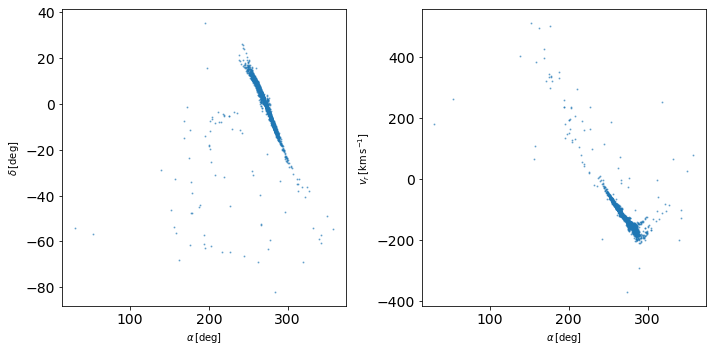

In [32]:

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True)

axes[0].scatter(stream_c.ra.degree,
                stream_c.dec.degree, s=1, alpha=0.5)
#axes[0].set_xlim(250, 220)
#axes[0].set_ylim(-15, 15)

axes[1].scatter(stream_c.ra.degree,
                stream_c.radial_velocity.to(u.km/u.s), s=1, alpha=0.5)
#axes[1].set_xlim(250, 220)
#axes[1].set_ylim(-100, 0)

axes[0].set_xlabel(r'$\alpha\,[{\rm deg}]$')
axes[1].set_xlabel(r'$\alpha\,[{\rm deg}]$')
axes[0].set_ylabel(r'$\delta\,[{\rm deg}]$')
axes[1].set_ylabel(r'$v_r\,[{\rm km}\,{\rm s}^{-1}]$')

fig.tight_layout()

In [47]:
end_points=coord.SkyCoord(ra=[300., 250]*u.deg,
                        dec=[-20, 20]*u.deg)

In [51]:
#rotate in stream reference frame 
fr = gc.GreatCircleICRSFrame.from_endpoints(end_points[0], end_points[1],
                                            ra0=np.nanmean(stream_c.ra))
stream_c_fr = stream_c.transform_to(fr)

[(0.0, 5.0), (-30.0, 30.0)]

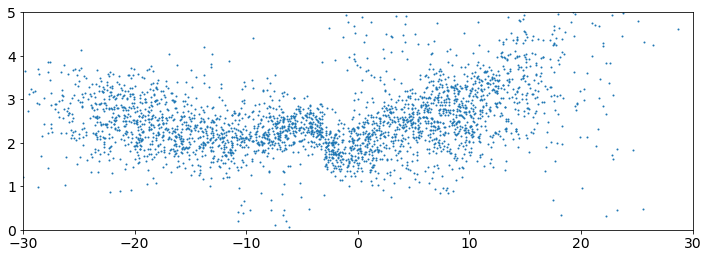

In [58]:
fig, ax=plt.subplots(figsize=(12, 4))

ax.scatter(stream_c_fr.phi1, stream_c_fr.phi2, s=1)
ax.set(ylim=[0, 5], xlim=[-30, 30])

In [ ]:
#fav_stream= st['pos'][:,60]

In [ ]:
#r=np.nansum(fav_stream**2, axis=0)**0.5

In [ ]:
#bd['pos'][0][60]

In [ ]:
#fig, ax=plt.subplots(figsize=(12, 4))
#plt.scatter(fav_stream[0], fav_stream[1], s=1, alpha=0.5, c='k')
#ax.scatter(bd['pos'][0][60][0], bd['pos'][1][60][0],  c='b', s=100, alpha=0.5, label='Particle')


In [ ]:
#np.save(path_data+'/herquinst_stream_snap60.npy', fav_stream)